# This GNN let you know if a specific graph has a Hamiltonian Cycle

In [1]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from time import time

In [3]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [4]:
%run utils_user_graph_2.ipynb     #this is were my function was stored

In [5]:
def gen_q_dict_hamiltonian_cycle(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for Hamiltonian Cycle as a maximization problem.
    
    Input:
        nx_G: graph as a NetworkX graph object
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get a penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = -penalty

    # all diagonal terms get a reward
    for u in nx_G.nodes:
        Q_dic[(u, u)] = penalty

    return Q_dic

In [6]:
def postprocess_gnn_hamiltonian_cycle(best_bitstring, nx_graph):
    """
    Helper function to postprocess Hamiltonian Cycle results from GNN.

    Input:
        best_bitstring: bitstring as torch tensor
        nx_graph: networkx Graph object
    Output:
        has_hamiltonian_cycle: True if a Hamiltonian cycle is found, False otherwise
        cycle_nodes: Order of nodes in the Hamiltonian cycle (list of integers)
    """

    # Convert the best bitstring tensor to a list
    bitstring_list = list(best_bitstring)

    # Extract the order of nodes in the cycle based on active bits
    cycle_nodes = [node for node, entry in enumerate(bitstring_list) if entry == 1]

    # Check if the cycle is valid (i.e., includes all nodes and forms a cycle)
    has_hamiltonian_cycle = False
    if len(cycle_nodes) == nx_graph.number_of_nodes() and nx_graph.has_edge(cycle_nodes[-1], cycle_nodes[0]):
        has_hamiltonian_cycle = True

    return has_hamiltonian_cycle, cycle_nodes

In [7]:
# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 20 # Change this parameter acording to the graph 

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

User graph

In [8]:
lista_de_aristas = [(0, 1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9), (0,10),
                    (1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10),
                   (2,3), (2,4), (2,5), (2,6), (2,7), (2,8), (2,9), (2,10), (2,11), (2,12), (2,13), (2,14), (2,15), (1,16),
                   (3,4), (3,5), (3,6), (3,7), (3,8), (3,9), (3,10), (3,11), (3,12), (3,13), (3,14), (3,15), (3,16), (3,17),
                   (4,5), (4,6), (4,7),
                   (5,6), (5,8), (5,9), (5,10),
                   (6,7), (6,8), (6,9), (6,10),
                   (7,8), (7,9), (7,15), (7,16), (7,17), (7,18), (7,19),
                   (8,9), (8,10), (8,11), (8,12), (8,13), (8,14),
                   (9,10), (9,13), (9,15), (9,17), (9,19),
                   (10,11), (10, 12), (10,14), (10,16), (10,18), (10,0),
                   (11,12), (11,13), (11,15), (11,17), (11,19), (11,1),
                   (12,13), (12,14), (12,16), (12,18), (12,0),
                   (13,14), (13,16), (13,18), (13,0),
                   (14,15), (14,17), (14,19), (14,1),
                   (15,16), (15,17), (15,18), (15,19), (15,0),
                   (16,17), (16,18), (16,19), (16,0), (16,1),
                   (17,18),(17,19), (17,0), (17, 1), (17,2),
                   (18,19), (18,0), (18,1), (18,2), (18,3),
                   (19,0), (19,1), (19,2), (19,3), (19,4), (19,5), (19,6)]

In [9]:
lista_de_nodos = [i for i in range(20)]

In [10]:
nx_graph = generate_graph(lista_de_nodos, lista_de_aristas)

In [11]:
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph

q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_hamiltonian_cycle(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)


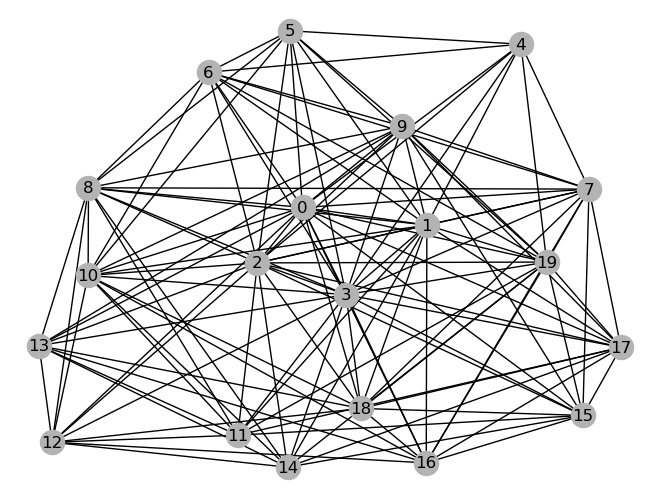

In [12]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [13]:
# Establish pytorch GNN + optimizer for Hamiltonian Cycle
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': n,  # Number of nodes in the graph for Hamiltonian Cycle
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)


In [14]:
print('Running GNN...')
gnn_start = time()
_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: -52.880462646484375
Epoch: 1000, Loss: -64.7647705078125
Epoch: 2000, Loss: -89.27180480957031
Epoch: 3000, Loss: -128.03973388671875
Epoch: 4000, Loss: -165.2288055419922
Epoch: 5000, Loss: -188.1097869873047
Epoch: 6000, Loss: -199.80406188964844
Epoch: 7000, Loss: -205.61538696289062
Epoch: 8000, Loss: -208.56982421875
Epoch: 9000, Loss: -210.11817932128906
Epoch: 10000, Loss: -210.9512176513672
Epoch: 11000, Loss: -211.4086151123047
Epoch: 12000, Loss: -211.66357421875
Epoch: 13000, Loss: -211.80731201171875
Epoch: 14000, Loss: -211.8891143798828
Stopping early on epoch 14274 (patience: 100)
GNN training (n=20) took 113.969
GNN final continuous loss: -211.9045867919922
GNN best continuous loss: -211.9045867919922


In [15]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN for Hamiltonian Cycle
has_hamiltonian_cycle, cycle_nodes = postprocess_gnn_hamiltonian_cycle(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

if has_hamiltonian_cycle:
    print(f'Hamiltonian Cycle found by GNN with nodes: {cycle_nodes}')
    print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')
else:
    print('No Hamiltonian Cycle found by GNN')

Hamiltonian Cycle found by GNN with nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Took 113.989s, model training took 113.971s


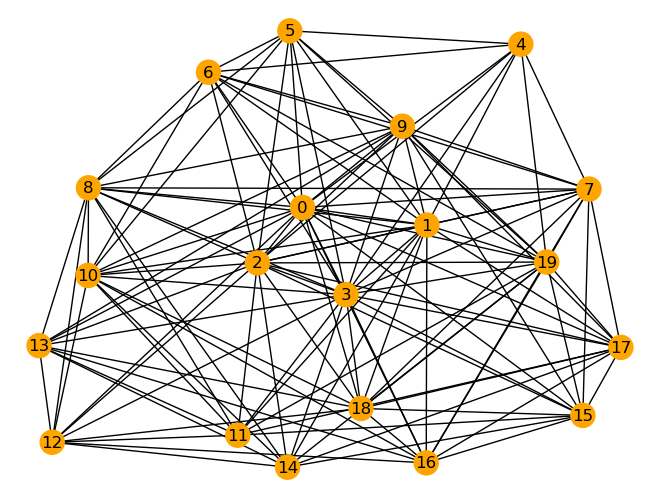

In [16]:
# Visualize result for Hamiltonian Cycle
color_map = ['orange' if node in cycle_nodes else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)
